# 3. CNN-1D para texto (con embeddings preentrenados)


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os, numpy as np, pandas as pd, random
from sklearn.model_selection import train_test_split

# Ruta de tu proyecto/dataset (ajústala si cambiaste)
PROJECT_DIR = r"C:\Users\elias\OneDrive\Desktop\MachineLearning\JBOOKS\Project3DL2"
DATA_PATH   = rf"{PROJECT_DIR}\jarvis-calling-hiring-contest\Resume\Resume.csv"

TEXT_COL  = "Resume_str"
LABEL_COL = "Category"

SEED = 42
random.seed(SEED); np.random.seed(SEED)

try:
    train_df, val_df, test_df
except NameError:
    df = pd.read_csv(DATA_PATH).dropna(subset=[TEXT_COL, LABEL_COL]).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=0.20, random_state=SEED, stratify=df[LABEL_COL])
    val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=SEED, stratify=temp_df[LABEL_COL])

all_labels = sorted(train_df[LABEL_COL].unique())
label2id = {c:i for i,c in enumerate(all_labels)}
id2label = {i:c for c,i in label2id.items()}
NUM_CLASSES = len(all_labels)

print("train/val/test:", train_df.shape, val_df.shape, test_df.shape, "| NUM_CLASSES:", NUM_CLASSES)


train/val/test: (1987, 4) (248, 4) (249, 4) | NUM_CLASSES: 24


In [3]:
import re, unicodedata

def clean_text_min(s: str) -> str:
    if not isinstance(s, str): return ""
    s = unicodedata.normalize("NFKC", s).lower()
    s = re.sub(r"<[^>]+>", " ", s)
    s = re.sub(r"[^\w\s]", " ", s, flags=re.UNICODE)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def simple_tokenize(s: str):
    return clean_text_min(s).split()

train_tokens = [simple_tokenize(t) for t in train_df[TEXT_COL].tolist()]
val_tokens   = [simple_tokenize(t) for t in val_df[TEXT_COL].tolist()]
test_tokens  = [simple_tokenize(t) for t in test_df[TEXT_COL].tolist()]

y_train = train_df[LABEL_COL].map(label2id).values.astype(np.int64)
y_val   = val_df[LABEL_COL].map(label2id).values.astype(np.int64)
y_test  = test_df[LABEL_COL].map(label2id).values.astype(np.int64)


In [4]:
from collections import Counter

MAX_VOCAB = 50000
PAD, UNK = "<pad>", "<unk>"

def build_vocab(token_lists, max_vocab=MAX_VOCAB):
    cnt = Counter()
    for toks in token_lists: cnt.update(toks)
    most_common = [w for w,_ in cnt.most_common(max_vocab-2)]
    itos = [PAD, UNK] + most_common
    stoi = {w:i for i,w in enumerate(itos)}
    return itos, stoi

itos, stoi = build_vocab(train_tokens, MAX_VOCAB)
vocab_size = len(itos)
print("vocab_size:", vocab_size)

def encode_tokens(token_lists, stoi_map, seq_len):
    X = np.zeros((len(token_lists), seq_len), dtype=np.int64)  # PAD=0
    for i, toks in enumerate(token_lists):
        ids = [stoi_map.get(t, 1) for t in toks]               # UNK=1
        ids = ids[:seq_len]
        X[i, :len(ids)] = ids
    return X

_X_cache = {}
def get_encoded(seq_len):
    if seq_len not in _X_cache:
        Xtr = encode_tokens(train_tokens, stoi, seq_len)
        Xva = encode_tokens(val_tokens,   stoi, seq_len)
        Xte = encode_tokens(test_tokens,  stoi, seq_len)
        _X_cache[seq_len] = (Xtr, Xva, Xte)
    return _X_cache[seq_len]


vocab_size: 36218


In [5]:
from gensim.models import Word2Vec
import numpy as np, os, hashlib

def train_word2vec(token_lists, emb_dim=200, window=5, min_count=1, sg=1, negative=5, epochs=10, seed=SEED):
    w2v = Word2Vec(
        sentences=token_lists, vector_size=emb_dim, window=window,
        min_count=min_count, sg=sg, negative=negative,
        workers=max(1, os.cpu_count()-1), epochs=epochs, seed=seed
    )
    return w2v

def build_embedding_matrix_safe(w2v, itos):
    emb_dim = w2v.vector_size
    vocab_hash = hashlib.sha1(("|".join(itos)).encode()).hexdigest()[:12]
    M = np.random.uniform(-0.05, 0.05, size=(len(itos), emb_dim)).astype(np.float32)
    M[0] = 0.0  # PAD
    for idx, tok in enumerate(itos):
        if tok in w2v.wv:
            M[idx] = w2v.wv[tok]
    return M


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class NumpyTextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.as_tensor(X, dtype=torch.long)
        self.y = torch.as_tensor(y, dtype=torch.long)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_loaders(Xtr, ytr, Xva, yva, batch_size=64):
    tr = NumpyTextDataset(Xtr, ytr)
    va = NumpyTextDataset(Xva, yva)
    train_dl = DataLoader(tr, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
    val_dl   = DataLoader(va, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    return train_dl, val_dl


In [7]:
import torch.nn as nn
import torch

class TextCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes, emb_matrix=None,
                 filter_sizes=(2,3,4,5), num_filters=200, dropout=0.5, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(emb_dim, num_filters, k, padding=0),
                nn.BatchNorm1d(num_filters),     # <— BN ayuda mucho
                nn.ReLU()
            ) for k in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes) * 2, num_classes)  # *2 por max+avg

    def forward(self, x):
        emb = self.embedding(x)        # [B,L,E]
        emb = emb.transpose(1,2)       # [B,E,L]
        feats = []
        for conv in self.convs:
            h = conv(emb)              # [B,F,L’]
            maxp = torch.max(h, dim=2).values
            avgp = torch.mean(h, dim=2)
            feats.append(torch.cat([maxp, avgp], dim=1))  # [B,2F]
        z = torch.cat(feats, dim=1)    # [B, 2F*|ks|]
        z = self.dropout(z)
        return self.fc(z)

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np, torch, torch.nn as nn

def compute_metrics_np(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"accuracy":acc, "precision_macro":prec, "recall_macro":rec, "f1_macro":f1}

def evaluate_model(model, dl, device):
    model.eval()
    all_preds, all_y = [], []
    with torch.no_grad():
        for xb, yb in dl:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_y.append(yb.cpu().numpy())
    y_pred = np.concatenate(all_preds); y_true = np.concatenate(all_y)
    return compute_metrics_np(y_true, y_pred), (y_true, y_pred)

def train_one(model, train_dl, val_dl, *, epochs, lr, class_weights=None, device=None, patience=3, use_amp=True):
    device = device or (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    criterion = nn.CrossEntropyLoss(
        weight=(torch.tensor(class_weights, dtype=torch.float32, device=device) if class_weights is not None else None)
    )
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and torch.cuda.is_available()))
    best_f1, best_state, bad = -1.0, None, 0

    for ep in range(1, epochs+1):
        model.train()
        run = 0.0
        for xb, yb in train_dl:
            xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(use_amp and torch.cuda.is_available())):
                logits = model(xb)
                loss = criterion(logits, yb)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer); scaler.update()
            run += loss.item()

        val_metrics, _ = evaluate_model(model, val_dl, device)
        print(f"Epoch {ep:02d} | loss={run/len(train_dl):.4f} | val_f1={val_metrics['f1_macro']:.4f}")

        if val_metrics["f1_macro"] > best_f1:
            best_f1 = val_metrics["f1_macro"]
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"Early stopping en epoch {ep}. Mejor f1_macro val={best_f1:.4f}")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_f1


Epoch 01 | loss=4.1069 | val_f1=0.0938
Epoch 02 | loss=3.1244 | val_f1=0.3203
Epoch 03 | loss=2.4759 | val_f1=0.4383
Epoch 04 | loss=1.8671 | val_f1=0.5027
Epoch 05 | loss=1.5072 | val_f1=0.5724
Epoch 06 | loss=1.2281 | val_f1=0.5724
Epoch 07 | loss=0.9448 | val_f1=0.5851
Epoch 08 | loss=0.8140 | val_f1=0.6651
Epoch 09 | loss=0.7344 | val_f1=0.6704
Epoch 10 | loss=0.6743 | val_f1=0.6420
Epoch 11 | loss=0.5844 | val_f1=0.6953
Epoch 12 | loss=0.5592 | val_f1=0.6844
Epoch 13 | loss=0.4435 | val_f1=0.6799
Epoch 14 | loss=0.4785 | val_f1=0.6871
Epoch 15 | loss=0.4364 | val_f1=0.7078
Epoch 16 | loss=0.3474 | val_f1=0.6952
Epoch 17 | loss=0.4089 | val_f1=0.7219
Epoch 18 | loss=0.3702 | val_f1=0.7251
Epoch 19 | loss=0.3624 | val_f1=0.6776
Epoch 20 | loss=0.3133 | val_f1=0.6921
Epoch 21 | loss=0.2654 | val_f1=0.6824
Epoch 22 | loss=0.2746 | val_f1=0.6761
Epoch 23 | loss=0.3308 | val_f1=0.7479
Epoch 24 | loss=0.3214 | val_f1=0.6895
Epoch 25 | loss=0.2381 | val_f1=0.7046
Epoch 26 | loss=0.2546 | 

,precision,recall,f1-score,support
ACCOUNTANT,1.000000,1.000000,1.000000,12.000000
ADVOCATE,0.727273,0.666667,0.695652,12.000000
AGRICULTURE,1.000000,0.666667,0.800000,6.000000
APPAREL,0.800000,0.444444,0.571429,9.000000
ARTS,0.666667,0.545455,0.600000,11.000000
AUTOMOBILE,0.000000,0.000000,0.000000,3.000000
AVIATION,0.909091,0.833333,0.869565,12.000000
BANKING,1.000000,0.583333,0.736842,12.000000
BPO,0.250000,0.500000,0.333333,2.000000
BUSINESS-DEVELOPMENT,0.800000,0.666667,0.727273,12.000000


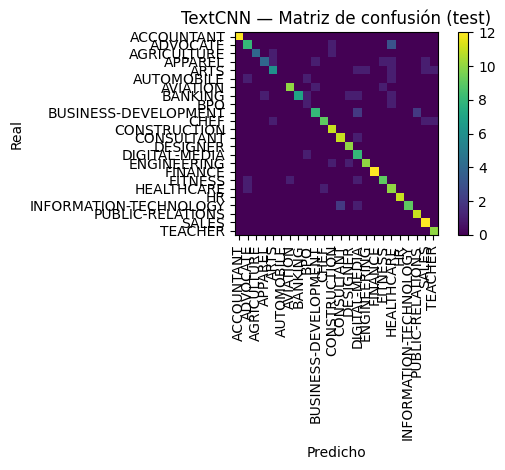

ROC-AUC macro (OvR): 0.982
Top-2 accuracy: 0.8675


In [9]:
# Hiperparámetros por defecto (sin grid)
SEQ_LEN = 384
EMB_DIM = 200
FILTER_SIZES = (2,3,4,5)
NUM_FILTERS = 200
DROPOUT = 0.5
BATCH = 64
EPOCHS = 100
LR = 1e-3

# Datos
Xtr, Xva, Xte = get_encoded(SEQ_LEN)
train_dl, val_dl = make_loaders(Xtr, y_train, Xva, y_val, batch_size=BATCH)

# Word2Vec con train_tokens
w2v = train_word2vec(train_tokens, emb_dim=EMB_DIM, epochs=10)
embM = build_embedding_matrix_safe(w2v, itos)

# Modelo
model = TextCNN(
    vocab_size=vocab_size, emb_dim=EMB_DIM, num_classes=NUM_CLASSES,
    emb_matrix=embM, filter_sizes=FILTER_SIZES, num_filters=NUM_FILTERS,
    dropout=DROPOUT, pad_idx=0
)

# Pesos de clase y entrenamiento
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight="balanced", classes=np.arange(NUM_CLASSES), y=y_train)

model, best_val = train_one(
    model, train_dl, val_dl,
    epochs=EPOCHS, lr=LR, class_weights=cw, patience=10, use_amp=True
)
print("Mejor f1_macro en val:", best_val)

# Evaluación en test
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dl = DataLoader(NumpyTextDataset(Xte, y_test), batch_size=BATCH, shuffle=False)

model = model.to(device).eval()
all_probs, all_preds, all_true = [], [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device, non_blocking=True)
        logits = model(xb)
        probs  = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(probs.argmax(dim=1).cpu().numpy())
        all_true.append(yb.numpy())

y_prob = np.concatenate(all_probs, axis=0)
y_pred = np.concatenate(all_preds, axis=0)
y_true = np.concatenate(all_true, axis=0)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
acc = accuracy_score(y_true, y_pred)
prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted", zero_division=0)
print({"accuracy":acc, "precision_macro":prec_m, "recall_macro":rec_m, "f1_macro":f1_m,
       "precision_weighted":prec_w, "recall_weighted":rec_w, "f1_weighted":f1_w})

# Reporte por clase y CM
rep = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(NUM_CLASSES)], digits=4, output_dict=True)
import pandas as pd; display(pd.DataFrame(rep).transpose().head(30))

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt, numpy as np
plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("TextCNN — Matriz de confusión (test)")
plt.colorbar()
ticks = np.arange(NUM_CLASSES)
plt.xticks(ticks, [id2label[i] for i in range(NUM_CLASSES)], rotation=90)
plt.yticks(ticks, [id2label[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicho"); plt.ylabel("Real")
plt.tight_layout(); plt.show()

# ROC-AUC macro (OvR) y Top-2
try:
    roc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR):", round(float(roc_macro),4))
except Exception as e:
    print("ROC-AUC no disponible:", e)

top2 = (np.argsort(-y_prob, axis=1)[:, :2] == y_true.reshape(-1,1)).any(axis=1).mean()
print("Top-2 accuracy:", round(float(top2),4))


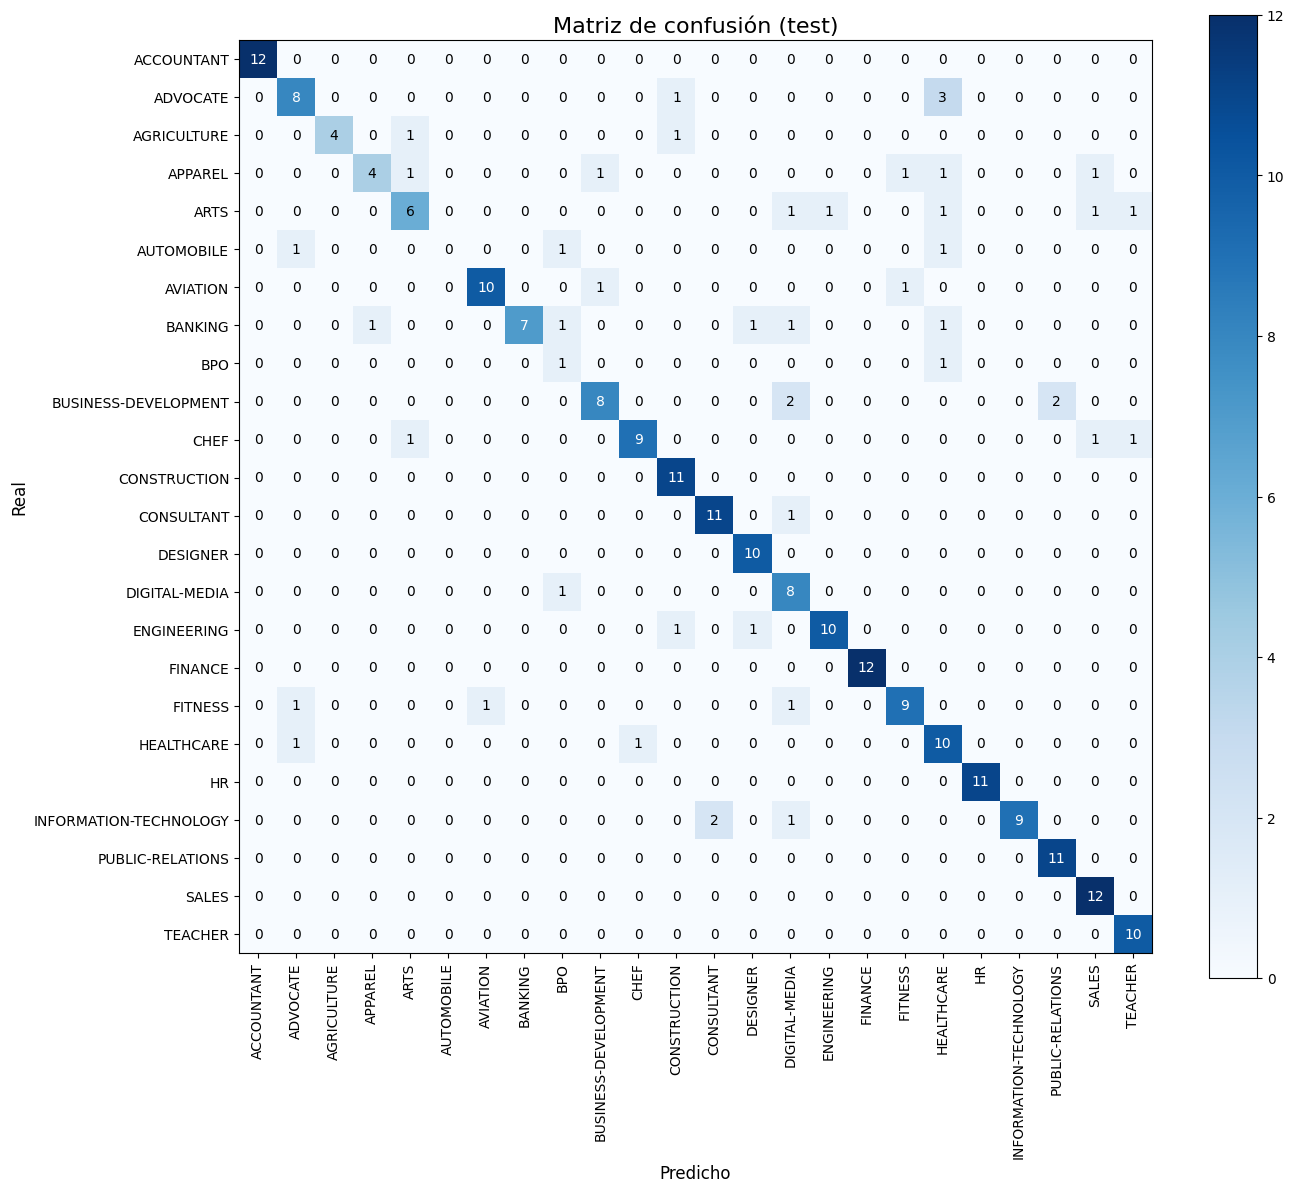

In [10]:
# Matriz de confusión con figura más grande y anotaciones
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(14, 12))  # ajustar tamaño aquí
im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set_title("Matriz de confusión (test)", fontsize=16)
ticks = np.arange(len(id2label))
labels = [id2label[i] for i in ticks]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels, rotation=90, fontsize=10)
ax.set_yticklabels(labels, fontsize=10)
ax.set_xlabel("Predicho", fontsize=12)
ax.set_ylabel("Real", fontsize=12)

# Añadir los números en cada celda
fmt = "d"
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black", fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
from sklearn.metrics import roc_auc_score

try:
    roc_macro_ovr = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
    print("ROC-AUC macro (OvR) en test:", round(float(roc_macro_ovr), 4))
except Exception as e:
    print("ROC-AUC no disponible:", e)


ROC-AUC macro (OvR) en test: 0.982


In [12]:
def predict_texts(text_list, model=model, max_len=100):
    # Tokenize using the same process as in training
    tokens_list = [simple_tokenize(text) for text in text_list]
    # Convert to ids using the same vocabulary
    X = encode_tokens(tokens_list, stoi, max_len)
    # Infer device from model parameters and move tensor there
    device = next(model.parameters()).device
    X = torch.tensor(X, dtype=torch.long).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(X)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        pred = prob.argmax(axis=1)
    labels = [id2label[i] for i in pred]
    return labels, prob

# Example:
labels, prob = predict_texts(["Experienced data scientist with NLP background."])
print(f"Predicted label: {labels[0]}")
print(f"Confidence: {prob[0].max():.4f}")


Predicted label: BUSINESS-DEVELOPMENT
Confidence: 0.3183


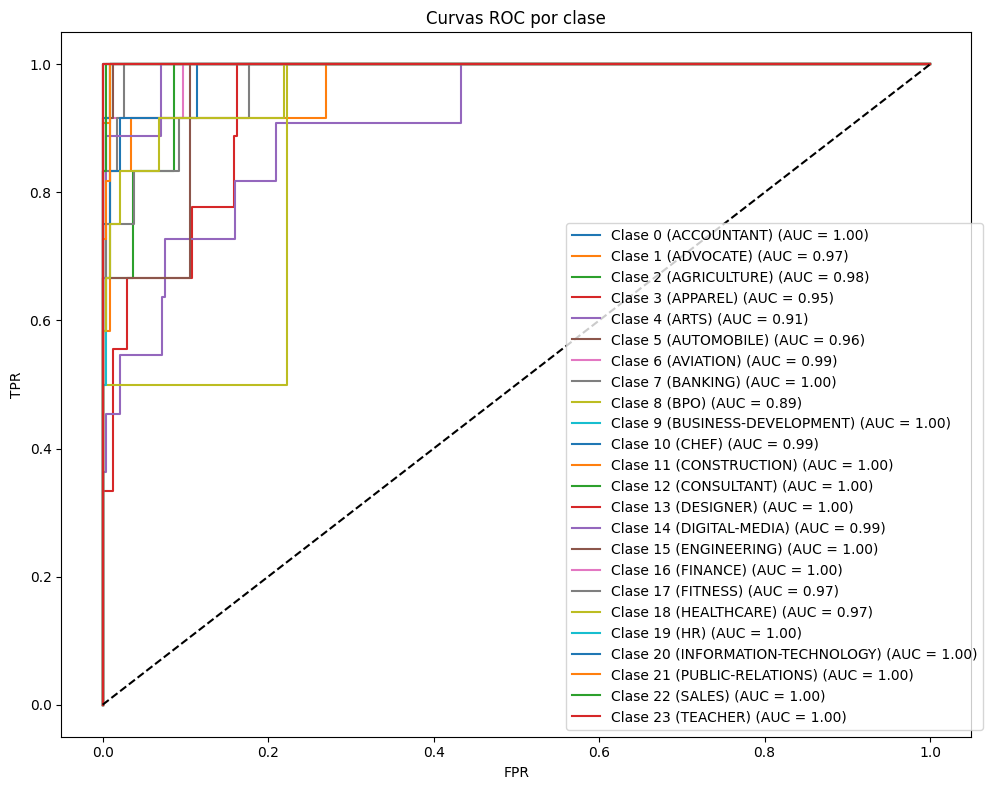

In [13]:
# 8. Curva ROC
# Import only the missing utilities
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# We already have y_prob and y_true from previous computations
probs = y_prob

labels_bin = label_binarize(y_true, classes=np.arange(NUM_CLASSES))

plt.figure(figsize=(10, 8))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'Clase {i} ({id2label.get(i,"")}) (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curvas ROC por clase')
plt.legend(loc='lower right', bbox_to_anchor=(1.02, 0))
plt.tight_layout()
plt.show()

,precision,recall,f1-score,support
AUTOMOBILE,0.000000,0.000000,0.000000,3.0
BPO,0.250000,0.500000,0.333333,2.0
APPAREL,0.800000,0.444444,0.571429,9.0
ARTS,0.666667,0.545455,0.600000,11.0
HEALTHCARE,0.555556,0.833333,0.666667,12.0
DIGITAL-MEDIA,0.533333,0.888889,0.666667,9.0
ADVOCATE,0.727273,0.666667,0.695652,12.0
BUSINESS-DEVELOPMENT,0.800000,0.666667,0.727273,12.0
BANKING,1.000000,0.583333,0.736842,12.0
macro avg,0.783912,0.776199,0.765778,249.0


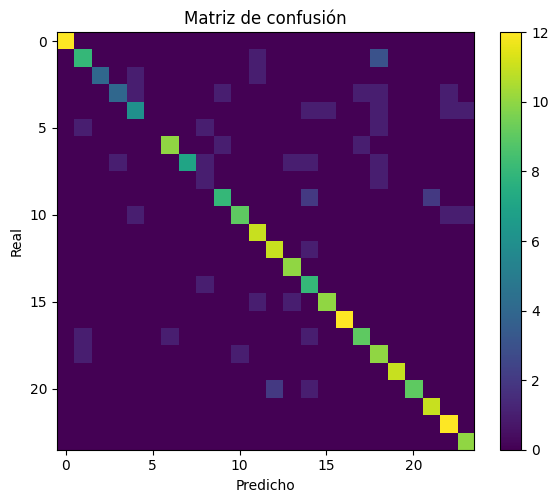

[(3, 'ADVOCATE', 'HEALTHCARE'),
 (2, 'INFORMATION-TECHNOLOGY', 'CONSULTANT'),
 (2, 'BUSINESS-DEVELOPMENT', 'PUBLIC-RELATIONS'),
 (2, 'BUSINESS-DEVELOPMENT', 'DIGITAL-MEDIA'),
 (1, 'INFORMATION-TECHNOLOGY', 'DIGITAL-MEDIA'),
 (1, 'HEALTHCARE', 'CHEF'),
 (1, 'HEALTHCARE', 'ADVOCATE'),
 (1, 'FITNESS', 'DIGITAL-MEDIA'),
 (1, 'FITNESS', 'AVIATION'),
 (1, 'FITNESS', 'ADVOCATE')]

: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# y_true, y_pred, y_prob: del último eval en test (ajusta si tus nombres cambian)
rep = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(NUM_CLASSES)],
                            output_dict=True, digits=4)
df_rep = pd.DataFrame(rep).transpose().sort_values('f1-score', ascending=True)
display(df_rep.head(10))  # clases más débiles

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5)); plt.imshow(cm, interpolation="nearest"); plt.colorbar()
plt.title("Matriz de confusión"); plt.xlabel("Predicho"); plt.ylabel("Real"); plt.tight_layout(); plt.show()

# Top confusiones
pairs = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i!=j and cm[i,j]>0:
            pairs.append((cm[i,j], id2label[i], id2label[j]))
pairs = sorted(pairs, reverse=True)[:10]
pairs
